In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.model_selection import KFold, train_test_split
import numpy as np
from tqdm import tqdm  

# Image preprocessing
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),      
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1), 
    transforms.RandomRotation(20),          
    transforms.Resize((224, 224)),          
    transforms.ToTensor(),                  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
])

# Dataset path
data_dir = 'dataset'
batch_size = 32
num_epochs = 5
k_folds = 3
num_classes = 3

dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
dataset_size = len(dataset)
indices = list(range(dataset_size))

# Divide the training set and test set
train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42, stratify=dataset.targets)
test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Training the model
def train_model(model, criterion, optimizer, dataloader, dataset_size):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    
    return epoch_loss, epoch_acc

def validate_model(model, criterion, dataloader, dataset_size):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    
    return epoch_loss, epoch_acc

# Cross Validation
train_indices = np.array(train_indices)
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    train_sampler = SubsetRandomSampler(train_indices[train_idx])
    val_sampler = SubsetRandomSampler(train_indices[val_idx])
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    
    model = models.resnet101(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, len(train_idx))
        val_loss, val_acc = validate_model(model, criterion, val_loader, len(val_idx))
        
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
    
    print(f'Best Val Acc: {best_acc:.4f}')
    
    # Save the best model
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f'resnet_model_101_fold_1{fold + 1}.pth')

Fold 1/3


C:\Users\wjc20\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wjc20\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5
----------


Train Loss: 0.7642 Acc: 0.6687
Val Loss: 0.2701 Acc: 0.9708
Epoch 2/5
----------


Train Loss: 0.2104 Acc: 0.9729
Val Loss: 0.0905 Acc: 0.9792
Epoch 3/5
----------


Train Loss: 0.0794 Acc: 0.9875
Val Loss: 0.0548 Acc: 0.9833
Epoch 4/5
----------


Train Loss: 0.0310 Acc: 0.9938
Val Loss: 0.0416 Acc: 0.9875
Epoch 5/5
----------


Train Loss: 0.0322 Acc: 0.9938
Val Loss: 0.0399 Acc: 0.9875
Best Val Acc: 0.9875
Fold 2/3
Epoch 1/5
----------


Train Loss: 0.7689 Acc: 0.6479
Val Loss: 0.2824 Acc: 0.9667
Epoch 2/5
----------


Train Loss: 0.1999 Acc: 0.9792
Val Loss: 0.0610 Acc: 0.9917
Epoch 3/5
----------


Train Loss: 0.0648 Acc: 0.9917
Val Loss: 0.0410 Acc: 0.9917
Epoch 4/5
----------


Train Loss: 0.0472 Acc: 0.9875
Val Loss: 0.0225 Acc: 0.9958
Epoch 5/5
----------


Train Loss: 0.0518 Acc: 0.9875
Val Loss: 0.0172 Acc: 1.0000
Best Val Acc: 1.0000
Fold 3/3
Epoch 1/5
----------


Train Loss: 0.7500 Acc: 0.6521
Val Loss: 0.2622 Acc: 0.9875
Epoch 2/5
----------


Train Loss: 0.1959 Acc: 0.9750
Val Loss: 0.0769 Acc: 0.9958
Epoch 3/5
----------


Train Loss: 0.0818 Acc: 0.9833
Val Loss: 0.0310 Acc: 0.9958
Epoch 4/5
----------


Train Loss: 0.0453 Acc: 0.9938
Val Loss: 0.0273 Acc: 0.9958
Epoch 5/5
----------


Train Loss: 0.0342 Acc: 0.9896
Val Loss: 0.0211 Acc: 0.9958
Best Val Acc: 0.9958


In [3]:
# Evaluate on the test set
model.load_state_dict(torch.load('resnet_model_101_fold_11.pth'))
test_loss, test_acc = validate_model(model, criterion, test_loader, len(test_indices))
print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

C:\Users\wjc20\AppData\Local\Temp\ipykernel_17024\3417282747.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet_model_101_fold_11.p

Test Loss: 0.0198 Acc: 1.0000


In [4]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F


class ConvertToRGB:
    def __call__(self, img):
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        return img


data_transforms = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Loading the model
model_path = 'resnet_model_101_fold_11.pth'  
num_classes = 3
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


image_path = 'Flower28.jpg'  
image = Image.open(image_path)
image = data_transforms(image)
image = image.unsqueeze(0)  


image = image.to(device)


with torch.no_grad():
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)
    predicted_class = preds.item()
    predicted_prob = probabilities[0][preds].item()


class_names = ['flower', 'pod', 'seed']  # 请根据实际情况修改
predicted_label = class_names[predicted_class]

print(f'The image is classified as: {predicted_label} with a probability of {predicted_prob:.4f}')



C:\Users\wjc20\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\wjc20\AppData\Local\Temp\ipykernel_17024\363783136.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.

The image is classified as: flower with a probability of 0.9359


C:\Users\wjc20\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wjc20\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\wjc20\AppData\Local\Temp\ipykernel_11356\3844451364.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_o

Accuracy: 0.9223
F1 Score: 0.9214
Recall: 0.9223
Precision: 0.9258


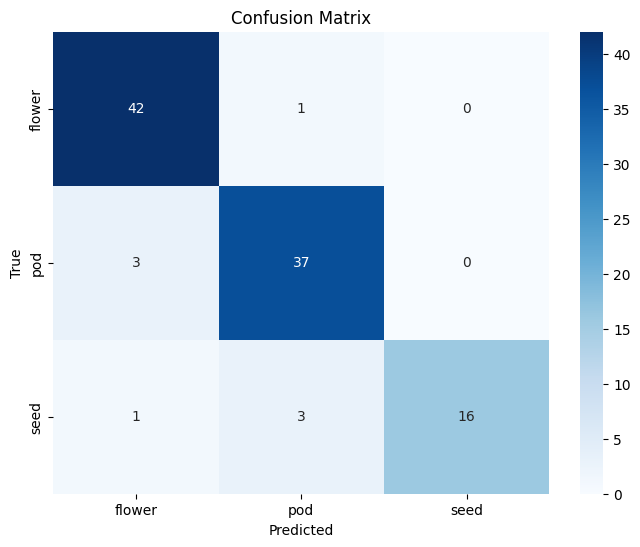

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_data_dir = 'downloads'
batch_size = 32
num_classes = 3


test_dataset = datasets.ImageFolder(test_data_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model_path = 'resnet_model_101_fold_11.pth'  
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Classify and calculate indicators
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')


# draw the Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()